(10, 5000)
[[ 0.00000000e+000  0.00000000e+000  2.64029329e-003 ... -1.67557893e+164
  -1.80892679e+164 -1.95288688e+164]
 [ 0.00000000e+000  0.00000000e+000  1.75466645e-003 ... -1.22068259e+164
  -1.31782836e+164 -1.42270529e+164]
 [ 0.00000000e+000  0.00000000e+000  2.19908545e-003 ... -1.44895508e+164
  -1.56426749e+164 -1.68875683e+164]
 ...
 [ 0.00000000e+000  0.00000000e+000  5.03380416e-004 ... -5.77942890e+163
  -6.23937407e+163 -6.73592312e+163]
 [ 0.00000000e+000  0.00000000e+000  2.35342619e-003 ... -1.52823654e+164
  -1.64985842e+164 -1.78115935e+164]
 [ 0.00000000e+000  0.00000000e+000  2.73504630e-003 ... -1.72424359e+164
  -1.86146433e+164 -2.00960553e+164]]


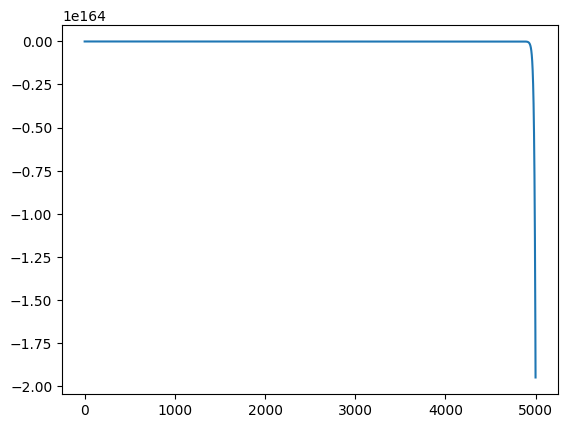

In [4]:
import numpy as np
from scipy.signal import hilbert
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Number of brain regions
X = 10
# Time steps
T = 5000
# Parameters for the Wilson-Cowan equations
tau_e, tau_i = 10, 10
alpha_e, alpha_i = 1.3, 2
theta_e, theta_i = 4, 3.7
beta = 0.4
# Global coupling
G = 0.1
# Time delay (in time steps)
delay = 2
# Structural connectivity matrix
SC = np.random.rand(X, X)
# Excitatory and inhibitory variables
E = np.random.rand(X)
I = np.random.rand(X)
# Time-step size
dt = 0.1

# Time series container
time_series_E = np.zeros((X, T))

# Wilson-Cowan equations update
def update(E, I, past_E, SC):
    dE = (-E + (1 - E) * alpha_e * np.tanh(E - beta * I + theta_e + G * SC.dot(past_E))) / tau_e
    dI = (-I + alpha_i * np.tanh(E - I + theta_i)) / tau_i
    return E + dE * dt, I + dI * dt

# Simulating Wilson-Cowan dynamics
for t in range(T):
    if t < delay:
        past_E = E  # Use current state for first time steps
    else:
        past_E = time_series_E[:, t - delay]
    
    E, I = update(E, I, past_E, SC)
    time_series_E[:, t] = E

# # Converting to BOLD signal using the Hilbert transform
# BOLD_signal = np.abs(hilbert(time_series_E))

def balloon_windkessel(S, dt):
    num_regions, simulation_time = S.shape
    BOLD = np.zeros_like(S)
    k1 = 7
    k2 = 2
    k3 = 2
    alpha = 0.32
    tau_s = 0.8
    tau_f = 0.4
    tau_o = 0.4
    E = 0.4

    s = np.zeros((num_regions, simulation_time))
    f = np.zeros_like(s)
    v = np.zeros_like(s)
    q = np.zeros_like(s)
    
    for t in range(1, simulation_time):
        s[:, t] = s[:, t-1] + dt * (S[:, t] - (k1 + 1) * s[:, t-1] + k1 * f[:, t-1])
        f[:, t] = f[:, t-1] + dt * s[:, t-1]
        v[:, t] = v[:, t-1] + dt * (alpha * (S[:, t] - f[:, t]) - 1/tau_s * v[:, t-1])
        q[:, t] = q[:, t-1] + dt * (alpha * (S[:, t] - E * f[:, t]) - 1/tau_f * q[:, t-1])
        BOLD[:, t] = v[:, t] - q[:, t]
        
    return BOLD

BOLD_signal = balloon_windkessel(time_series_E, dt)

print(BOLD_signal.shape)
print(BOLD_signal)

# plot the bold signal
plt.plot(BOLD_signal[0, :])

# # Computing the functional connectivity matrix
# FC = np.zeros((X, X))
# for i in range(X):
#     for j in range(X):
#         corr, _ = pearsonr(BOLD_signal[i, :], BOLD_signal[j, :])
#         FC[i, j] = corr

# plt.imshow(FC, cmap='hot')
# plt.title('Functional Connectivity Matrix')
# plt.colorbar()
# plt.show()
